# Universal differential equation
Simon Frost (@sdwfrost), 2022-03-28

## Introduction

[Universal differential equations](https://arxiv.org/abs/2001.04385) combine neural networks with differential equation models, in order to combine domain-specific knowledge with data-driven insights. In this tutorial, we use a neural network to model the force of infection without making prior assumptions of the functional form, using noisy data of the number of new infections per day.

## Libraries

In [1]:
using Pkg
Pkg.activate("ude")

  Activating project at `~/Documents/GitHub/Julia-for-SciML/hands-on/ude`


In [2]:
using OrdinaryDiffEq
using Distributions
using DiffEqFlux, Lux
using Optimization
using OptimizationPolyalgorithms
using Random
using ComponentArrays
using Statistics
using Plots;

In [3]:
rng = Random.default_rng()
Random.seed!(123);

## Transitions

\begin{align}
    \frac{dS}{dt} &= -\beta S(t)I(t)\\ 
    \frac{dI}{dt} &= \beta S(t)I(t)-\gamma I(t)\\
    \frac{dC}{dt} &= \beta S(t)I(t)
\end{align}

In [4]:
function sir_ode(u,p,t)
    (S,I,C) = u
    (β,γ) = p
    dS = -β*S*I
    dI = β*S*I - γ*I
    dC = β*S*I
    [dS,dI,dC]
end;

## Settings

In [5]:
solver = RadauIIA3();

Although the model is in terms of proportions of susceptible, infected, and recovered individuals, we define the total population size, `N`, so we can generate random data of the number of new cases per day.

In [6]:
N = 1000.0
p = [0.5,0.25]
u0 = [0.99, 0.01, 0.0]
tspan = (0., 40.)
δt = 1;

## Solving the true model

In [7]:
sir_prob = ODEProblem(sir_ode, u0, tspan, p)
sir_sol = solve(sir_prob, solver, saveat = δt);

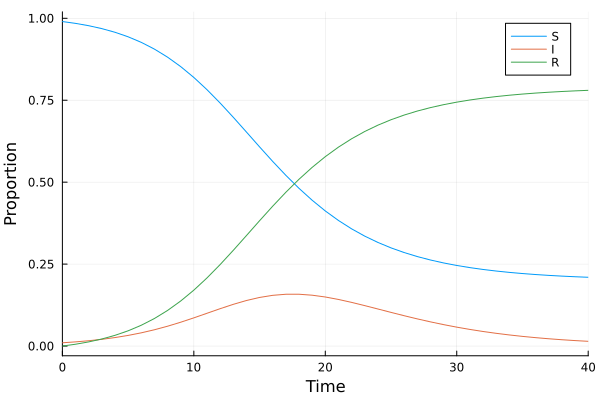

In [8]:
plot(sir_sol,
     xlabel = "Time",
     ylabel = "Proportion",
     labels = ["S" "I" "R"])

## Generating 'observed' data

We define the time over which the training data are generated, and generate noisy data corresponding to the number of new cases per day.

In [9]:
train_time = 30.0
tsdata = Array(sir_sol(0:δt:train_time))
cdata = diff(tsdata[3,:])
noisy_data = rand.(Poisson.(N .* cdata));

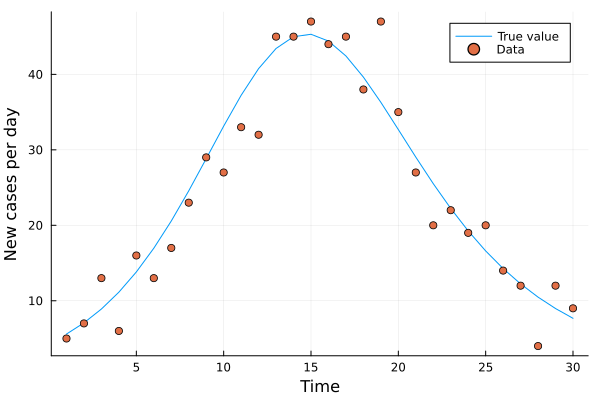

In [10]:
plot(1:δt:train_time, N .* cdata,
     xlabel = "Time",
     ylabel = "New cases per day",
     label = "True value")
scatter!(1:δt:train_time, noisy_data, label="Data")

foi1 = FastDense(1, 1, relu, bias=false)
p1_ = Float64.(initial_params(foi1))
length(p1_)##  Single layer network

We start by defining a single neural network layer with one input and one output and no bias parameter, which is the true relationship between `i` and the force of infection.

In [11]:
foi1 = Lux.Dense(1, 1, relu, bias=false)
p1_, st1 = Lux.setup(rng, foi1)
p1_, length(p1_)

((weight = Float32[1.5860611;;],), 1)

The following model allows one to change the function used to describe the force of infection, i.e. the per-capita rate at which susceptible individuals become infected.

In [34]:
function sir_ude(u,p_,t,foi, st)
    S,I,C = u
    β,γ = p
    λ= foi([I], p_, st)[1][1]
    dS = -λ*S
    dI = λ*S - γ*I
    dC = λ*S
    [dS, dI, dC]
end;

In [35]:
tspan_train = (0,train_time)
sir_ude1 = (u,p_,t) -> sir_ude(u,p_,t,foi1, st1)
prob_ude1 = ODEProblem(sir_ude1,
                      u0,
                      tspan_train,
                      p1_);

To fit this model, we first need to define a function that predicts the outcome given a set of parameters.

In [36]:
function predict(θ, prob)
    Array(solve(prob,
                solver;
                u0 = u0,
                p = θ,
                saveat = δt,
                sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end;

Secondly, we define a loss function that uses this predict function to calculate the loss between the predicted data and the true data. We employ a Poisson loss, as we are comparing our model against counts of new cases.

In [37]:
function loss(θ, prob)
    pred = predict(θ, prob)
    cpred = abs.(N*diff(pred[3,:]))
    Flux.poisson_loss(cpred, float.(noisy_data)), cpred
end;

We run this function once to make sure it is precompiled.

In [38]:
loss(prob_ude1.p, prob_ude1);

To keep track of the running of the model, we store the losses in a `Vector` and use a callback to report on the model fit every 10 epochs.

In [17]:
const losses1 = []
callback1 = function (p, l, pred)
    push!(losses1, l)
    numloss = length(losses1)
    if numloss % 10 == 0
        display("Epoch: " * string(numloss) * " Loss: " * string(l))
    end
    return false
end;

In [42]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p)->loss(x, prob_ude1), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p1_))
res_ude1 = Optimization.solve(optprob, OptimizationPolyalgorithms.PolyOpt(), callback=callback1)

"Epoch: 620 Loss: 46.39434672449694"

"Epoch: 630 Loss: 36.43205697980578"

"Epoch: 640 Loss: 26.050977198038506"

"Epoch: 650 Loss: 15.114743579282198"

"Epoch: 660 Loss: 3.452580725344372"

"Epoch: 670 Loss: -8.98614732168986"

"Epoch: 680 Loss: -22.135178338988688"

"Epoch: 690 Loss: -35.43392650802868"

"Epoch: 700 Loss: -47.2600376516064"

"Epoch: 710 Loss: -54.69635846795701"

"Epoch: 720 Loss: -56.649457949317345"

"Epoch: 730 Loss: -56.45193738134048"

"Epoch: 740 Loss: -56.50212237569375"

"Epoch: 750 Loss: -56.63738424745975"

"Epoch: 760 Loss: -56.65655302525394"

"Epoch: 770 Loss: -56.65182872007104"

"Epoch: 780 Loss: -56.65572714612519"

"Epoch: 790 Loss: -56.657674602245805"

"Epoch: 800 Loss: -56.65750509696803"

"Epoch: 810 Loss: -56.65758482578167"

"Epoch: 820 Loss: -56.65768436524299"

"Epoch: 830 Loss: -56.657680560010775"

"Epoch: 840 Loss: -56.65768264189337"

"Epoch: 850 Loss: -56.65768700304816"

"Epoch: 860 Loss: -56.65768675117436"

"Epoch: 870 Loss: -56.65768689313232"

"Epoch: 880 Loss: -56.65768709669628"

"Epoch: 890 Loss: -56.65768708640462"

"Epoch: 900 Loss: -56.657687096188525"

"Epoch: 910 Loss: -56.657687098526715"

u: ComponentVector{Float64}(weight = [0.493602344646379;;])

The fitted parameter in this model corresponds to the infectivity parameter, `β`.

In [43]:
res_ude1.minimizer, losses1[end]

((weight = [0.493602344646379;;]), -56.65768709902595)

This model is fast to converge to an optimum due to the small number of trainable parameters.

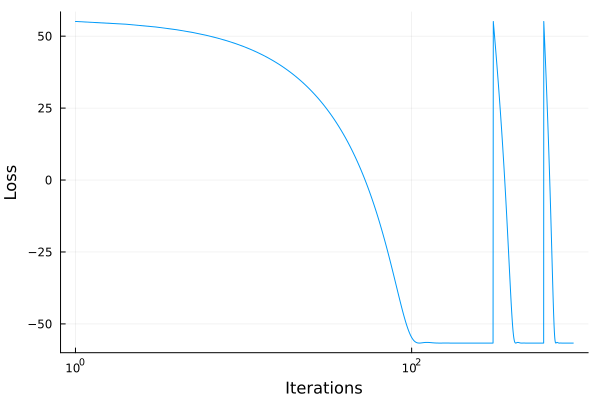

In [44]:
plot(losses1, xaxis = :log, xlabel = "Iterations", ylabel = "Loss", legend=false)

The fitted model provides a good fit to all the states, despite only being trained on a noisy representation of the number of new infections.

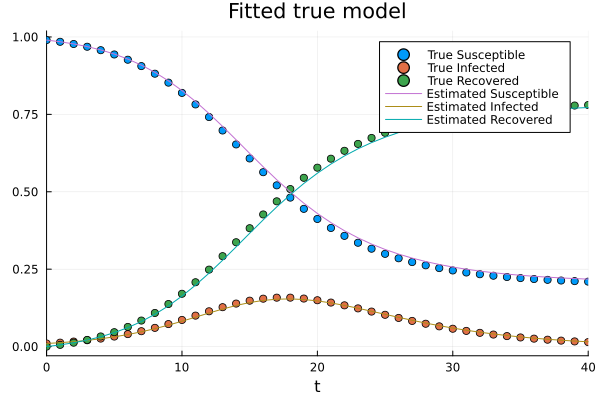

In [45]:
prob_ude1_fit = ODEProblem(sir_ude1, u0, tspan, res_ude1.minimizer)
sol_ude1_fit = solve(prob_ude1_fit, solver, saveat = δt)
scatter(sir_sol, label=["True Susceptible" "True Infected" "True Recovered"],title="Fitted true model")
plot!(sol_ude1_fit, label=["Estimated Susceptible" "Estimated Infected" "Estimated Recovered"])

This plots the relationship between `i` and the force of infection, `λ`, which shows a good match.

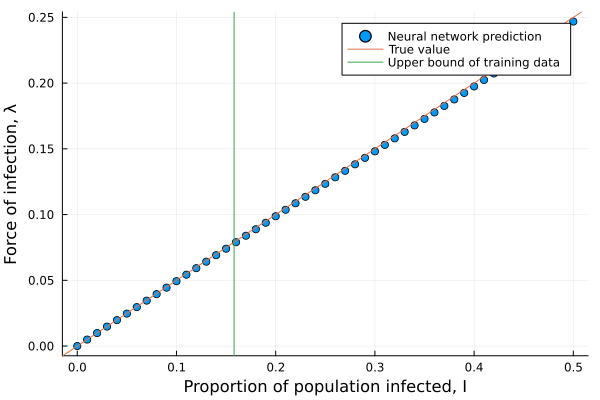

In [46]:
Imax = maximum(tsdata[2,:])
Igrid = 0:0.01:0.5
λ = [foi1([I],res_ude1.minimizer, st1)[1][1] for I in Igrid]
scatter(Igrid,λ,xlabel="Proportion of population infected, I",ylab="Force of infection, λ",label="Neural network prediction")
Plots.abline!(p[1],0,label="True value")
Plots.vline!([Imax],label="Upper bound of training data")

## Multiple layer network

In the absence of prior knowledge, we use a neural network with multiple layers.

In [74]:
Random.seed!(1234)
nhidden = 4
foi2 = Lux.Chain(Lux.Dense(1, nhidden, relu, init=Flux.glorot_uniform(gain=2)),
                     Lux.Dense(nhidden, nhidden, relu),
                     Lux.Dense(nhidden, 1, relu))
p2_, st2 = Lux.setup(rng, foi2)

((layer_1 = (weight = Float32[0.49557778; -0.38126603; -0.42284605; 0.107465595;;], bias = Float32[0.0; 0.0; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.15969938 -0.25347877 0.49135512 0.78781974; 0.8177637 0.035255868 0.58824235 -0.5106646; -0.6919587 -0.16589832 -0.77170587 0.78050417; -0.8402026 0.24172777 0.809115 0.047083568], bias = Float32[0.0; 0.0; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.20837806 0.16283458 -0.48723406 0.38921136], bias = Float32[0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [78]:
?Flux.init_params

No documentation found.

Binding `Flux.init_params` does not exist.


We wrap this neural network in a new `ODEProblem`.

In [70]:
sir_ude2 = (u,p_,t) -> sir_ude(u,p_,t,foi2, st2)
prob_ude2 = ODEProblem(sir_ude2,
                      u0,
                      tspan_train,
                      p2_);

We define a new data structure to store the losses from the fitting of this more complex model.

In [71]:
const losses2 = []
callback2 = function (p, l, pred)
    push!(losses2, l)
    numloss = length(losses2)
    if numloss % 10 == 0
        display("Epoch: " * string(numloss) * " Loss: " * string(l))
    end
    return false
end;

In [72]:
optf2 = Optimization.OptimizationFunction((x,p)->loss(x, prob_ude2), adtype)
optprob2 = Optimization.OptimizationProblem(optf2, ComponentVector{Float64}(p2_))
res_ude2 = Optimization.solve(optprob2, OptimizationPolyalgorithms.PolyOpt(), callback=callback2)

"Epoch: 10 Loss: -46.79926037468308"

"Epoch: 20 Loss: -51.4220018913606"

"Epoch: 30 Loss: -52.332849893124255"

"Epoch: 40 Loss: -52.681711889183276"

"Epoch: 50 Loss: -53.46893725489178"

"Epoch: 60 Loss: -54.76561455435265"

"Epoch: 70 Loss: -56.45966754507883"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 80 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 90 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 100 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 110 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 120 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 130 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 140 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 150 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 160 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 170 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 180 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 190 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 200 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 210 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 220 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 230 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 240 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 250 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 260 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 270 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 280 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 290 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, 

"Epoch: 300 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/stevenchiu/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/stevenchiu/.julia/packages/SciMLBase/y9NOj/src/integrator_interface.jl:496


"Epoch: 310 Loss: -56.66513928900252"

"Epoch: 320 Loss: -56.66513929888274"

"Epoch: 330 Loss: -56.66513920833483"

u: ComponentVector{Float64}(layer_1 = (weight = [0.6991807797399039; -0.3812660276889801; -0.4228460490703583; -0.027000490333794425;;], bias = [0.05949681531213866; 0.0; 0.0; 0.060437624698914345;;]), layer_2 = (weight = [-0.10428855101675928 -0.2534787654876709 0.49135512113571167 0.7944243178790527; 0.8983483498141173 0.03525586798787117 0.5882423520088196 -0.4997345599895566; -0.738569450994832 -0.16589832305908203 -0.7717058658599854 0.8559028021833632; -0.8402026295661926 0.2417277693748474 0.8091149926185608 0.04708356782793999], bias = [0.05984993092264943; 0.05985722498659796; 0.12671031375124223; 0.0;;]), layer_3 = (weight = [0.09030682314780224 0.24263830743106182 -0.6599796052511395 0.38921135663986206], bias = [0.0591222441143055;;]))

Overall, the 'true' model and the more flexible model give a comparable fit to the data in terms of the loss function.

In [51]:
losses1[end],losses2[end]

(-56.65768709902595, -56.66513921104841)

Consistent with this, the multilayer model gives a good fit when plotted alongside the data.

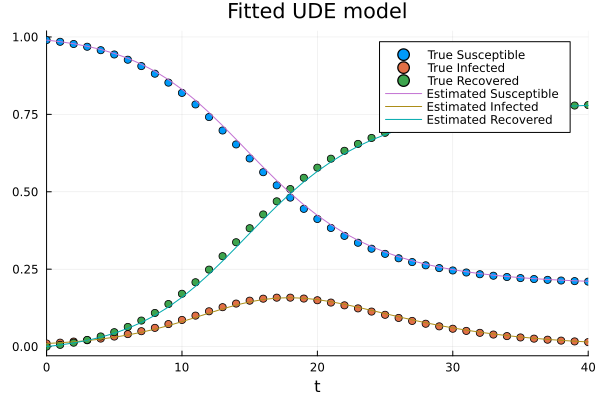

In [52]:
prob_ude2_fit = ODEProblem(sir_ude2, u0, tspan, res_ude2.minimizer)
sol_ude2_fit = solve(prob_ude2_fit, solver, saveat = δt)
scatter(sir_sol, label=["True Susceptible" "True Infected" "True Recovered"],title="Fitted UDE model")
plot!(sol_ude2_fit, label=["Estimated Susceptible" "Estimated Infected" "Estimated Recovered"])

This is the inferred functional relationship between the proportion of infected individuals and the force of infection.

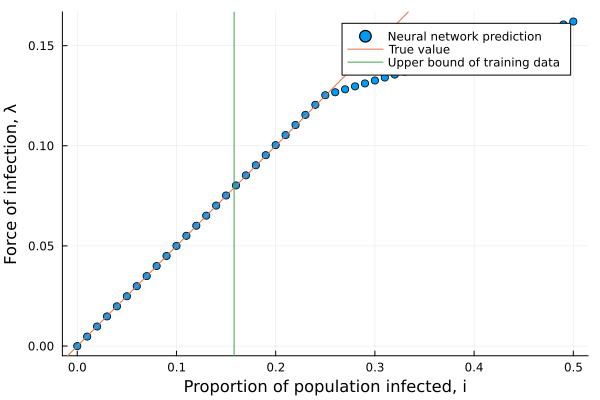

In [55]:
λ = [foi2([I],res_ude2.minimizer, st2)[1][1] for I in Igrid]
scatter(Igrid, λ, xlabel="Proportion of population infected, i", ylab="Force of infection, λ", label="Neural network prediction")
Plots.abline!(p[1], 0,label="True value")
Plots.vline!([Imax], label="Upper bound of training data")

## Discussion

The number of new infections per day is sufficient to fit an SIR model assuming the correct functional form for the force of infection. A universal differential equation that uses a multilayer neural network to infer the relationship between the proportion of infected individuals and the force of infection recovers the true relationship, at least for the range of the size of the infected subpopulation seen in the training data. As we would expect that the force of infection would be higher when there are more infected individuals, we could adapt the neural network to reflect a monotonic relationship, either by constraining the neural network, or by introducing a penalty term in the loss function.